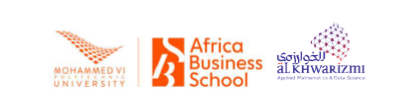

<h1 style='text-align: center;'>Numerical Linear Algebra & Parallel Computing</h1> 

<h2 style='text-align: center;'> MPI </h2>

####  Supervisors : Nouredine OUHADDOU - Mohamed Jalal Maaouni - Ibrahim EL MOUNTASSER


#### Author : Oumaima CHQAF

***

#### Exercise 1: Hello World

1- Write an MPI program which prints the message "Hello World"

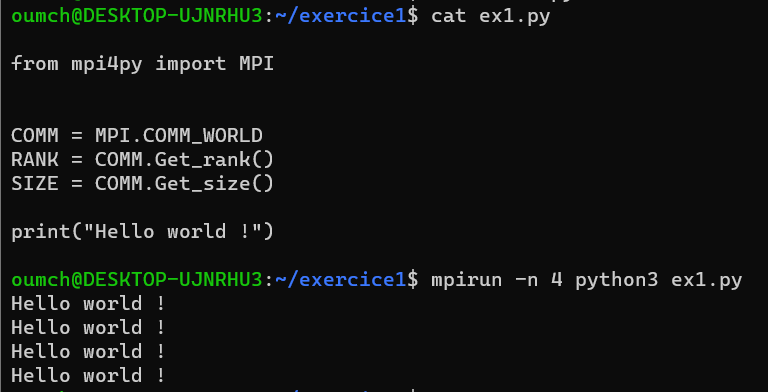

2- Modify your program so that each process prints out both its rank and the total number of processes P that the code is running on, i.e. the size of MPI_COMM_WORLD.

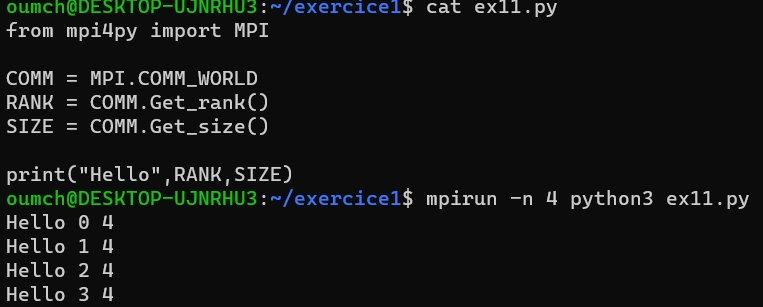

3- Modify your program so that only a single controller process (e.g. rank 0) prints out a message (very useful when you run with hundreds of processes).


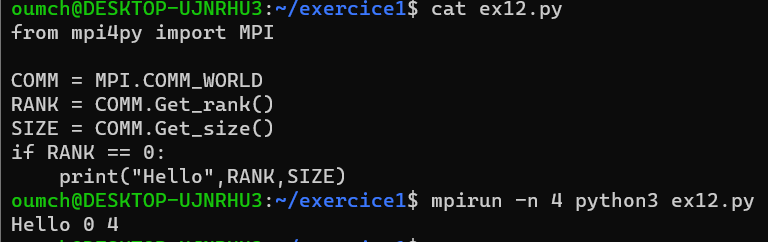

4- What happens if you omit the final MPI procedure call in your program?


The omission of the final MPI procedure call in an MPI program can lead to an improper termination of the MPI environment, causing memory leaks and other issues. The MPI environment may not be adequately finalized, resulting in unexpected behavior, such as hanging processes or incorrect results. To avoid such issues, it is imperative to ensure that the MPI program makes an explicit call to the MPI_Finalize() function at the end of the execution to properly finalize the MPI environment.

#### Exercise 2: Sharing Data

Create a program that obtains an integer input from the terminal and distributes it to all the MPI processes. Each process must display its rank and the received value. Keep reading values until a negative integer is entered.

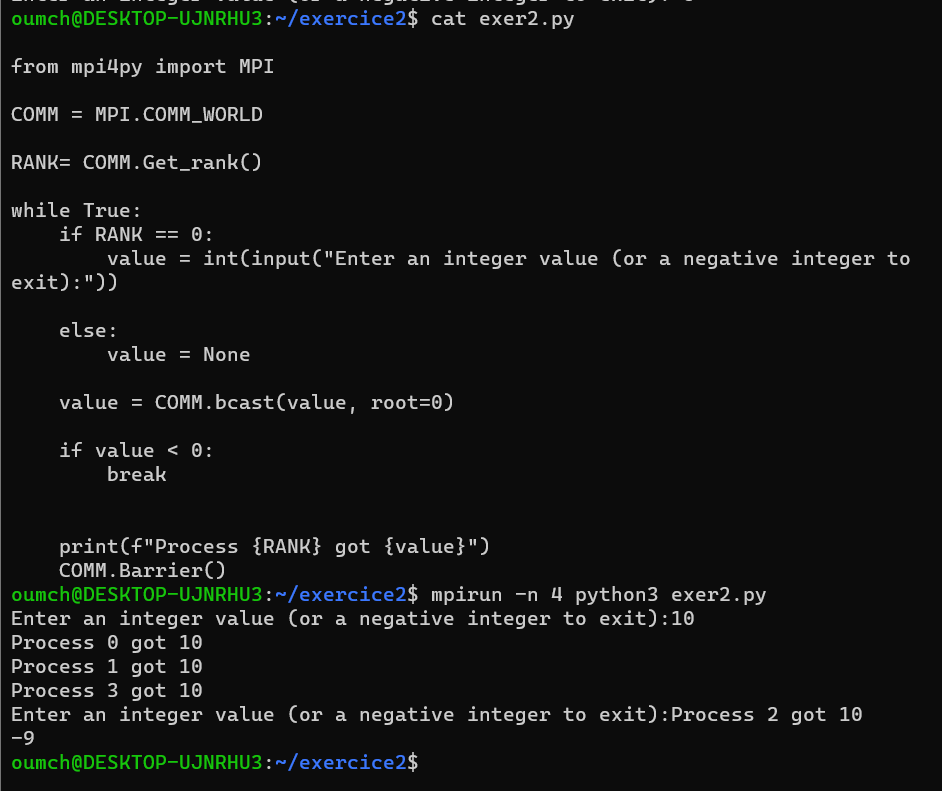

#### Exercise 3 Sending in a ring (broadcast by ring)

Write a program that takes data from process zero and sends it to all of the other processes by sending it in a ring. That is, process i should receive the data add the rank of the process to it then send it to process i+1, until the last process is reached. Assume that the data consists of a single integer. Process zero reads the data from the user. print the process rank and the value received.

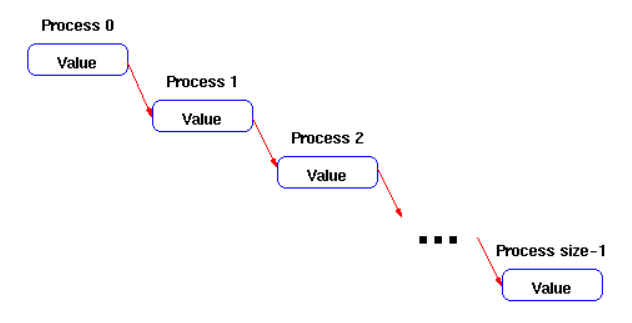

You may want to use these MPI routines in your solution: Send Recv

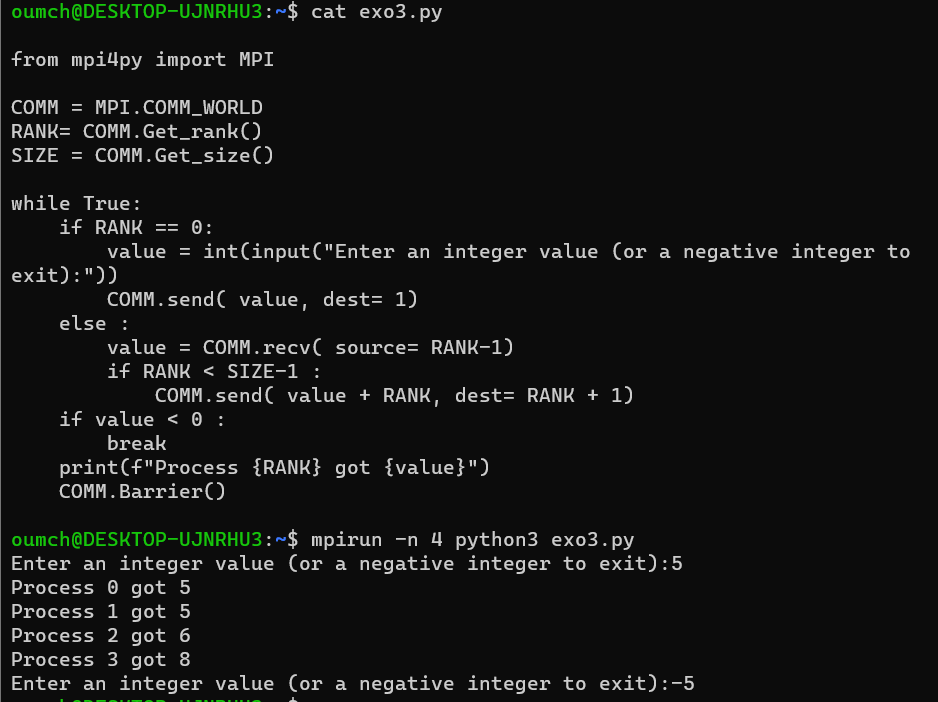

#### Exercise 4: Scattering Matrix


1- Create an n by m matrix A on processor 0.


2- Use MPI_Scatterv to send parts of the matrix to the other processors.

3- Processor 1 receives A(i,j) for i=0 to (n/2)-1 and j=m/2 to m-1.

4- Processor 2 receives A(i,j) for i=n/2 to n-1 and j=0 to (m/2)-1.

5- Processor 3 receives A(i,j) for i=n/2 to n-1 and j=m/2 to m-1.


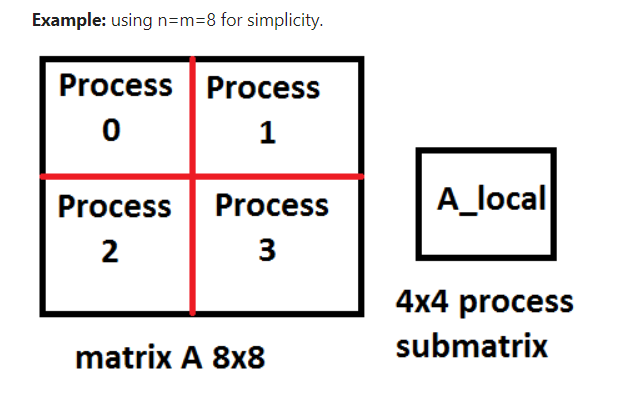

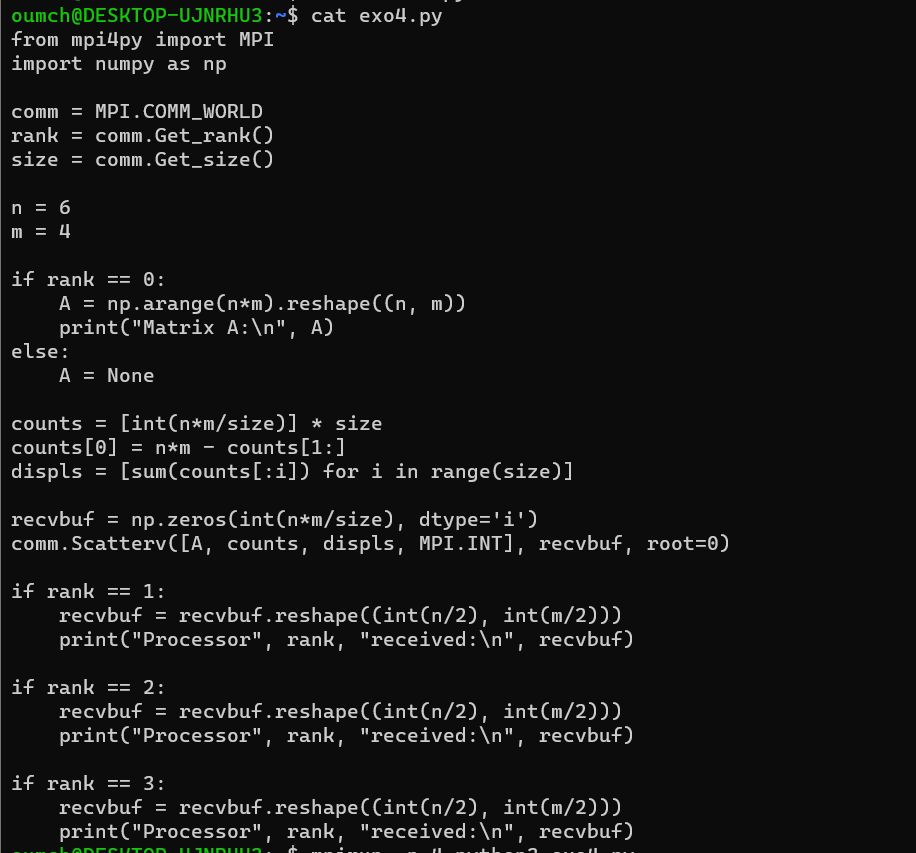

#### Exercise 5 Matrix vector product

1- Use the MatrixVectorMult.py file to implement the MPI version of matrix vector multiplication.

2- Process 0 compares the result with the dot product.


3- Plot the scalability of your implementation.

In [2]:
from mpi4py import MPI
import numpy as np
import time

# Matrix-vector multiplication function
def matrix_vector_mult(A, x):
    m = A.shape[0]
    n = A.shape[1]
    y = np.zeros((m,))
    for i in range(m):
        for j in range(n):
            y[i] += A[i,j]*x[j]
    return y

# MPI setup
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Initialize matrix and vector
m = 1000
n = 1000
A = np.random.rand(m, n)
x = np.random.rand(n,)

# Scatter the matrix and vector
sendcounts = [m//size]*size
sendcounts[-1] += m % size
senddispls = [sum(sendcounts[:i]) for i in range(size)]
local_A = np.zeros((sendcounts[rank], n), dtype=float)
comm.Scatterv([A, sendcounts, senddispls, MPI.DOUBLE], local_A, root=0)

sendcounts = [n//size]*size
sendcounts[-1] += n % size
senddispls = [sum(sendcounts[:i]) for i in range(size)]
local_x = np.zeros(sendcounts[rank], dtype=float)
comm.Scatterv([x, sendcounts, senddispls, MPI.DOUBLE], local_x, root=0)

# Matrix-vector multiplication on each process
local_y = matrix_vector_mult(local_A, local_x)

# Gather the results
recvcounts = [m//size]*size
recvcounts[-1] += m % size
recvdispls = [sum(recvcounts[:i]) for i in range(size)]
y = np.zeros((m,), dtype=float)
comm.Gatherv(local_y, [y, recvcounts, recvdispls, MPI.DOUBLE], root=0)

# Compute the dot product on the root process
if rank == 0:
    start_time = time.time()
    y_dot = np.dot(A, x)
    dot_time = time.time() - start_time
    
    # Compare the results
    error = np.linalg.norm(y-y_dot)
    print("CPU time of parallel multiplication using {} processes is {:.6f}".format(size, dot_time))
    print("The error comparing to the dot product is :", error)

CPU time of parallel multiplication using 1 processes is 0.062778
The error comparing to the dot product is : 7918.936347053175


#### Exercise 6: Pi calculation


An approximation to the value π can be obtained from the following expression :

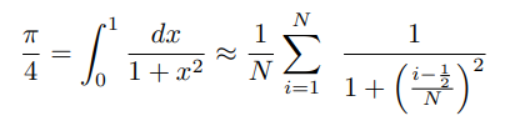

where the answer becomes more accurate with increasing N. Iterations over i are independent so the calculation can be parallelized.


For the following exercises you should set N = 840. This number is divisible by 2, 3, 4, 5, 6, 7 and 8 which is convenient when you parallelize the calculation!

1- Create a program where each process independently computes the value of π and prints it to the screen. Check that the values are correct (each process should print the same value)


2- Now arrange for different processes to do the computation for different ranges of i. For example, on two processes: rank 0 would do i = 0, 1, 2, . . . , N/2 - 1; rank 1 would do i = N/2, N/2 + 1, . . . , N-1.

1- Use the function MPI_Wtime (see below) to record the time it takes to perform the calculation. For a given value of N, does the time decrease as you increase the number of processes? Note that to ensure that the calculation takes a sensible amount of time (e.g. more than a second) you will probably have to perform the calculation of π several thousands of times.


2- Ensure your program works correctly if N is not an exact multiple of the number of processes P

In [1]:
from mpi4py import MPI
import math

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

N = 840

# Compute the value of pi independently on each process
pi_part = 0.0
for i in range(rank, N, size):
    pi_part += 1.0/(1.0 + ((i + 0.5)/N)**2)

pi_part *= 4.0/N

# Print the partial sum computed by each process
print("Process", rank, "partial sum:", pi_part)

# Accumulate the partial sums on the controller (rank 0)
if rank == 0:
    pi = pi_part
    for i in range(1, size):
        pi += comm.recv(source=i)
else:
    comm.send(pi_part, dest=0)

# Print the final result computed by the controller
if rank == 0:
    print("Computed pi:", pi)

# Measure the time taken for the computation
comm.Barrier() # synchronize all processes
t1 = MPI.Wtime()

num_runs = 10000 # number of times to compute pi
for i in range(num_runs):
    pi_part = 0.0
    for j in range(rank, N, size):
        pi_part += 1.0/(1.0 + ((j + 0.5)/N)**2)
    pi_part *= 4.0/N

    if rank == 0:
        pi = pi_part
        for j in range(1, size):
            pi += comm.recv(source=j)
    else:
        comm.send(pi_part, dest=0)

    if rank == 0 and i == 0:
        print("Computed pi:", pi)

# Record the time taken
comm.Barrier() # synchronize all processes
t2 = MPI.Wtime()

if rank == 0:
    print("Time taken:", t2 - t1)

Process 0 partial sum: 3.1415927716925873
Computed pi: 3.1415927716925873
Computed pi: 3.1415927716925873
Time taken: 2.15864750000037
